# Análisis de Clasificación con Optimización de Hiperparámetros

Este notebook implementa un análisis completo de clasificación utilizando el dataset de seguros médicos. Se incluye:
- Exploración inicial de datos
- Preprocesamiento
- Entrenamiento de modelos de clasificación
- Optimización de hiperparámetros
- Evaluación de modelos

**Nota**: Para este análisis, convertiremos el problema en clasificación binaria prediciendo si los costos del seguro son altos o bajos basándonos en la mediana.

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
# Configurar estilo de visualización
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Carga y Exploración Inicial de Datos

In [2]:
# Este comando conecta colab con drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Hacemos la conexion con la plantilla de datos a trabajar
path = "/content/drive/MyDrive/ColabTest/Clase Profe/Marchine Learning/Core/BD/insurance.csv"
df = pd.read_csv(path)

In [4]:
# Mostrar información básica del dataset
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras 5 filas:")
print(df.head())

print("\nInformación del dataset:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())

Dimensiones del dataset: (1338, 7)

Primeras 5 filas:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Estadístic

In [5]:
# Verificar valores faltantes
print("Valores faltantes por columna:")
print(df.isnull().sum())

# Verificar duplicados
print(f"\nNúmero de filas duplicadas: {df.duplicated().sum()}")

Valores faltantes por columna:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Número de filas duplicadas: 1


In [10]:
 #Identificar si exiten valores nulos
print("Valores nulos antes de la limpieza:")
print(df.isnull().sum())

Valores nulos antes de la limpieza:
age             0
sex             0
bmi             0
children        0
smoker          0
region          0
charges         0
high_charges    0
dtype: int64


In [12]:
# Revisamos los NaN si hay
filas_con_nan = df[df.isnull().any(axis=1)]

print("Filas que contienen al menos un valor NaN:")
print(filas_con_nan)

# También puedes verificar el total de NaN por columna
print("\nTotal de valores NaN por columna:")
print(df.isnull().sum())

# O simplemente verificar si hay algún NaN
total_nan = df.isnull().sum().sum()
print(f"\nTotal de valores NaN en todo el dataset: {total_nan}")

Filas que contienen al menos un valor NaN:
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges, high_charges]
Index: []

Total de valores NaN por columna:
age             0
sex             0
bmi             0
children        0
smoker          0
region          0
charges         0
high_charges    0
dtype: int64

Total de valores NaN en todo el dataset: 0


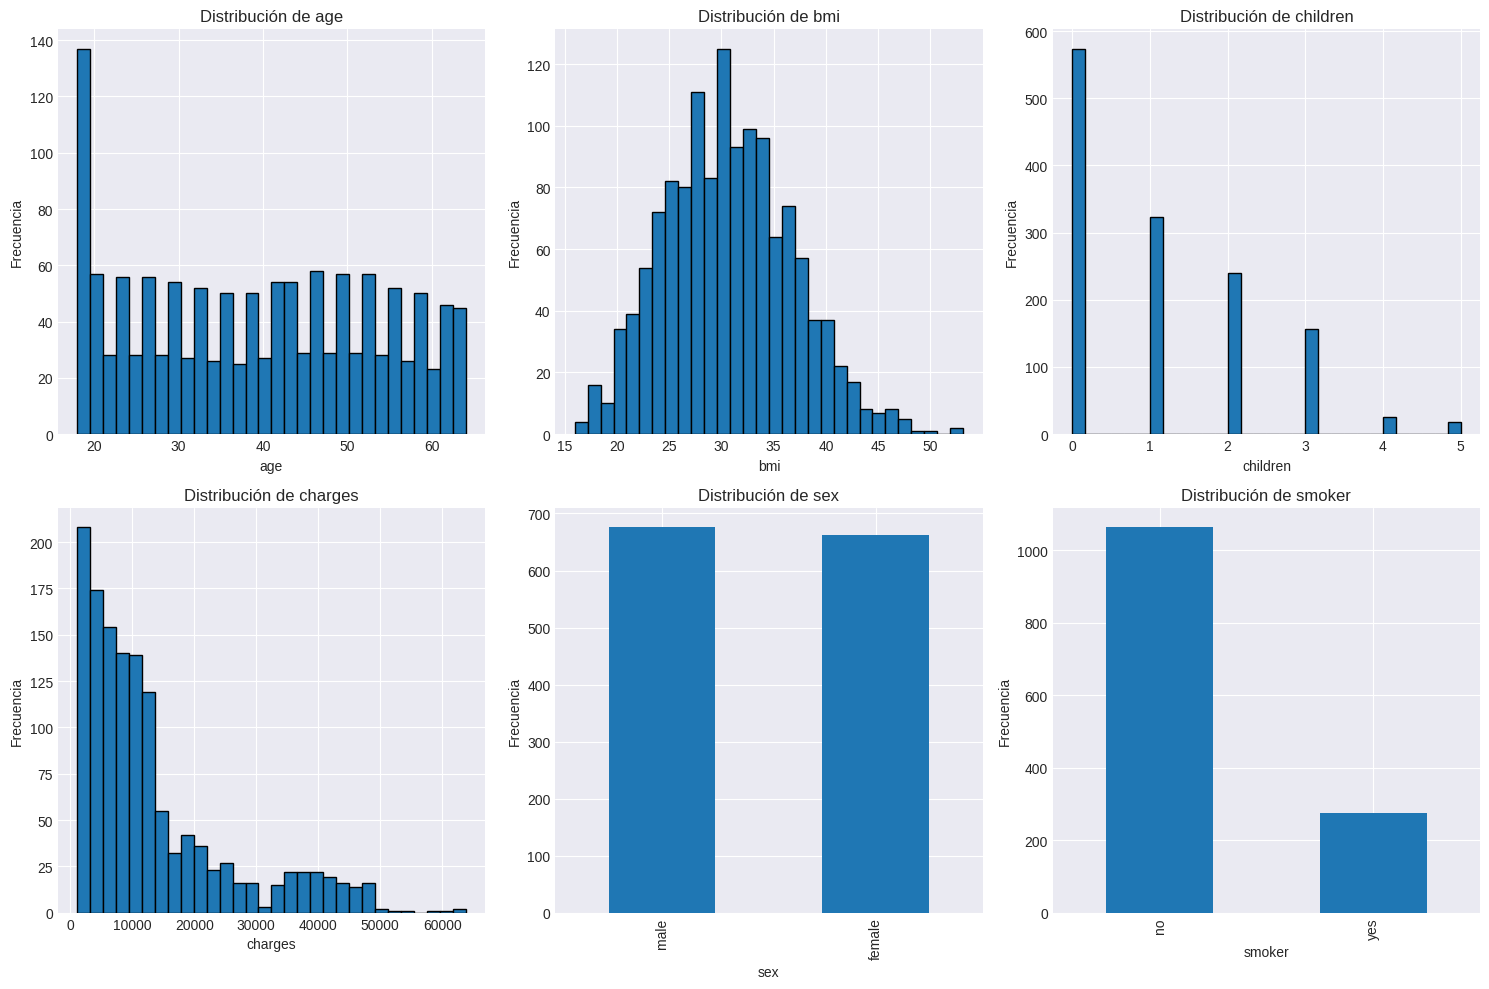

In [6]:
# Análisis de distribuciones
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Variables numéricas
numeric_cols = ['age', 'bmi', 'children', 'charges']
for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col], bins=30, edgecolor='black')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Variables categóricas
categorical_cols = ['sex', 'smoker']
for i, col in enumerate(categorical_cols, 4):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [7]:
# Detección de outliers usando IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detectar outliers en variables numéricas
print("Outliers detectados usando método IQR:")
for col in numeric_cols:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    print(f"\n{col}:")
    print(f"  - Número de outliers: {len(outliers)}")
    print(f"  - Porcentaje: {len(outliers)/len(df)*100:.2f}%")
    print(f"  - Límites: [{lower:.2f}, {upper:.2f}]")

Outliers detectados usando método IQR:

age:
  - Número de outliers: 0
  - Porcentaje: 0.00%
  - Límites: [-9.00, 87.00]

bmi:
  - Número de outliers: 9
  - Porcentaje: 0.67%
  - Límites: [13.70, 47.29]

children:
  - Número de outliers: 0
  - Porcentaje: 0.00%
  - Límites: [-3.00, 5.00]

charges:
  - Número de outliers: 139
  - Porcentaje: 10.39%
  - Límites: [-13109.15, 34489.35]


In [14]:
# Check value counts for the 'charges' column , hay charges: - Número de outliers: 139 revise y esta bien por que puede ser distintos tipos de cobranza
print(df['charges'].value_counts())

charges
1639.56310     2
2221.56445     1
19798.05455    1
13063.88300    1
13555.00490    1
              ..
1149.39590     1
37079.37200    1
4738.26820     1
2897.32350     1
4762.32900     1
Name: count, Length: 1337, dtype: int64


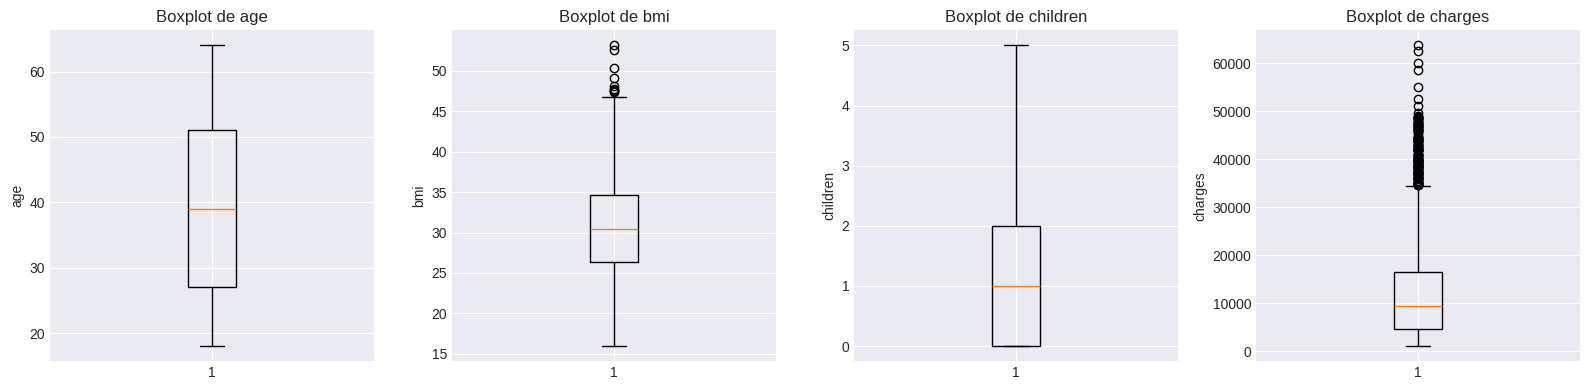

In [8]:
# Boxplots para visualizar outliers
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

In [9]:
# Crear variable objetivo binaria basada en la mediana de charges
median_charges = df['charges'].median()
df['high_charges'] = (df['charges'] > median_charges).astype(int)

print(f"Mediana de charges: ${median_charges:.2f}")
print(f"\nDistribución de la variable objetivo:")
print(df['high_charges'].value_counts())
print(f"\nPorcentaje de cada clase:")
print(df['high_charges'].value_counts(normalize=True) * 100)

Mediana de charges: $9382.03

Distribución de la variable objetivo:
high_charges
1    669
0    669
Name: count, dtype: int64

Porcentaje de cada clase:
high_charges
1    50.0
0    50.0
Name: proportion, dtype: float64


## 2. Preprocesamiento de Datos

In [15]:
# Separar características y variable objetivo
X = df.drop(['charges', 'high_charges'], axis=1)
y = df['high_charges']

# Identificar columnas numéricas y categóricas
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

print("Características numéricas:", numeric_features)
print("Características categóricas:", categorical_features)

Características numéricas: ['age', 'bmi', 'children']
Características categóricas: ['sex', 'smoker', 'region']


In [16]:
# One-Hot Encoding para variables categóricas
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print("Columnas después del One-Hot Encoding:")
print(X_encoded.columns.tolist())
print(f"\nNúmero de características: {X_encoded.shape[1]}")

Columnas después del One-Hot Encoding:
['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']

Número de características: 8


In [17]:
# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")
print(f"\nDistribución de clases en entrenamiento:")
print(y_train.value_counts(normalize=True))
print(f"\nDistribución de clases en prueba:")
print(y_test.value_counts(normalize=True))

Tamaño del conjunto de entrenamiento: (1070, 8)
Tamaño del conjunto de prueba: (268, 8)

Distribución de clases en entrenamiento:
high_charges
1    0.5
0    0.5
Name: proportion, dtype: float64

Distribución de clases en prueba:
high_charges
1    0.5
0    0.5
Name: proportion, dtype: float64


In [18]:
# Escalado de características numéricas
scaler = StandardScaler()

# Identificar columnas numéricas en el dataset codificado
numeric_cols_encoded = ['age', 'bmi', 'children']

# Crear copias para no modificar los originales
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Escalar solo las columnas numéricas
X_train_scaled[numeric_cols_encoded] = scaler.fit_transform(X_train[numeric_cols_encoded])
X_test_scaled[numeric_cols_encoded] = scaler.transform(X_test[numeric_cols_encoded])

print("Estadísticas después del escalado (conjunto de entrenamiento):")
print(X_train_scaled[numeric_cols_encoded].describe())

Estadísticas después del escalado (conjunto de entrenamiento):
                age           bmi      children
count  1.070000e+03  1.070000e+03  1.070000e+03
mean   5.644498e-17  1.726552e-16 -2.324205e-17
std    1.000468e+00  1.000468e+00  1.000468e+00
min   -1.504465e+00 -2.419406e+00 -9.115834e-01
25%   -9.363415e-01 -7.080394e-01 -9.115834e-01
50%   -1.314117e-02 -7.057597e-02 -9.261259e-02
75%    8.390438e-01  6.647383e-01  7.263582e-01
max    1.762244e+00  3.667818e+00  3.183271e+00


## 3. Implementación de Modelos de Clasificación

In [19]:
# Definir modelos base
models = {
    'Regresión Logística': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Árbol de Decisión': DecisionTreeClassifier(random_state=42)
}

# Entrenar y evaluar modelos base con validación cruzada
cv_scores = {}
base_models = {}

for name, model in models.items():
    # Validación cruzada
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores[name] = scores

    # Entrenar el modelo
    model.fit(X_train_scaled, y_train)
    base_models[name] = model

    # Predicciones
    y_pred = model.predict(X_test_scaled)

    print(f"\n{name}:")
    print(f"  - CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    print(f"  - Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Regresión Logística:
  - CV Accuracy: 0.9037 (+/- 0.0305)
  - Test Accuracy: 0.8993

KNN:
  - CV Accuracy: 0.8776 (+/- 0.0407)
  - Test Accuracy: 0.8918

Árbol de Decisión:
  - CV Accuracy: 0.8682 (+/- 0.0352)
  - Test Accuracy: 0.8806


/tmp/ipython-input-20-207395960.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=models.keys())


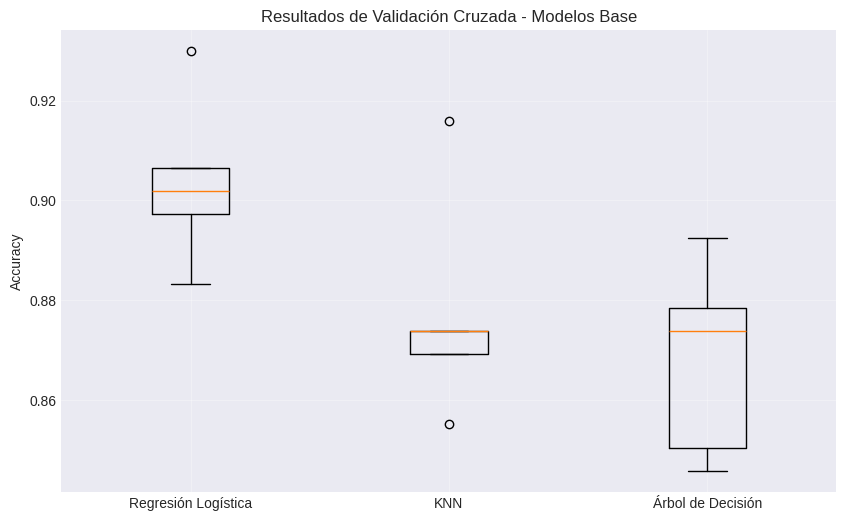

In [20]:
# Visualizar resultados de validación cruzada
plt.figure(figsize=(10, 6))
box_data = [cv_scores[name] for name in models.keys()]
plt.boxplot(box_data, labels=models.keys())
plt.title('Resultados de Validación Cruzada - Modelos Base')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

## 4. Optimización de Hiperparámetros

In [21]:
# Definir grillas de hiperparámetros para cada modelo
param_grids = {
    'Regresión Logística': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Árbol de Decisión': {
        'max_depth': [3, 5, 7, 9, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
}

In [22]:
# GridSearchCV
grid_search_results = {}
best_models_grid = {}

print("=== GridSearchCV ===")
for name, model in models.items():
    print(f"\nOptimizando {name}...")

    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train_scaled, y_train)

    grid_search_results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'results': grid_search.cv_results_
    }

    best_models_grid[name] = grid_search.best_estimator_

    print(f"  - Mejores parámetros: {grid_search.best_params_}")
    print(f"  - Mejor score CV: {grid_search.best_score_:.4f}")

=== GridSearchCV ===

Optimizando Regresión Logística...
  - Mejores parámetros: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
  - Mejor score CV: 0.9093

Optimizando KNN...
  - Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
  - Mejor score CV: 0.9000

Optimizando Árbol de Decisión...
  - Mejores parámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
  - Mejor score CV: 0.9224


In [23]:
# RandomizedSearchCV
from scipy.stats import uniform, randint

# Definir distribuciones para búsqueda aleatoria
param_distributions = {
    'Regresión Logística': {
        'C': uniform(0.001, 100),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'KNN': {
        'n_neighbors': randint(1, 20),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'Árbol de Decisión': {
        'max_depth': [3, 5, 7, 9, 11, 15, None],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'criterion': ['gini', 'entropy']
    }
}

random_search_results = {}
best_models_random = {}

print("\n=== RandomizedSearchCV ===")
for name, model in models.items():
    print(f"\nOptimizando {name}...")

    random_search = RandomizedSearchCV(
        model,
        param_distributions[name],
        n_iter=50,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    random_search.fit(X_train_scaled, y_train)

    random_search_results[name] = {
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'results': random_search.cv_results_
    }

    best_models_random[name] = random_search.best_estimator_

    print(f"  - Mejores parámetros: {random_search.best_params_}")
    print(f"  - Mejor score CV: {random_search.best_score_:.4f}")


=== RandomizedSearchCV ===

Optimizando Regresión Logística...
  - Mejores parámetros: {'C': np.float64(12.204823484477883), 'penalty': 'l1', 'solver': 'saga'}
  - Mejor score CV: 0.9093

Optimizando KNN...
  - Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
  - Mejor score CV: 0.8991

Optimizando Árbol de Decisión...
  - Mejores parámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 14}
  - Mejor score CV: 0.9243



Comparación de resultados:
                Modelo  Base CV Score  GridSearch CV Score  \
0  Regresión Logística         0.9037               0.9093   
1                  KNN         0.8776               0.9000   
2    Árbol de Decisión         0.8682               0.9224   

   RandomSearch CV Score  
0                 0.9093  
1                 0.8991  
2                 0.9243  


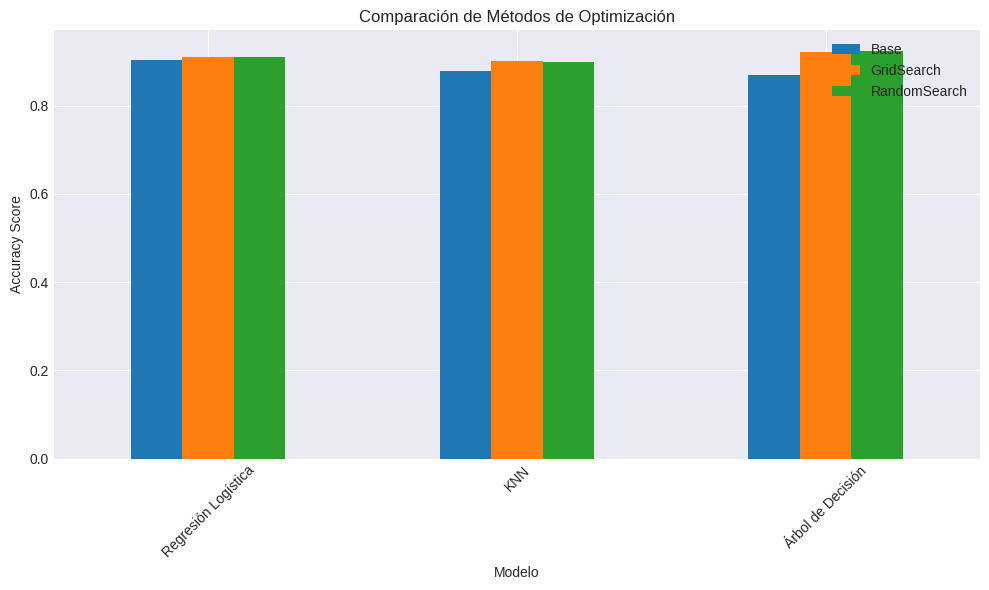

In [24]:
# Comparación de resultados
comparison_df = pd.DataFrame({
    'Modelo': list(models.keys()),
    'Base CV Score': [cv_scores[name].mean() for name in models.keys()],
    'GridSearch CV Score': [grid_search_results[name]['best_score'] for name in models.keys()],
    'RandomSearch CV Score': [random_search_results[name]['best_score'] for name in models.keys()]
})

print("\nComparación de resultados:")
print(comparison_df.round(4))

# Visualización
comparison_df.set_index('Modelo').plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de Métodos de Optimización')
plt.ylabel('Accuracy Score')
plt.legend(['Base', 'GridSearch', 'RandomSearch'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Evaluación de Modelos

In [25]:
# Función para evaluar modelos
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }

    return metrics, y_pred, y_pred_proba

# Evaluar todos los modelos optimizados
evaluation_results = {}
predictions = {}

print("=== Evaluación de Modelos Optimizados (GridSearch) ===")
for name, model in best_models_grid.items():
    metrics, y_pred, y_pred_proba = evaluate_model(model, X_test_scaled, y_test, name)
    evaluation_results[f"{name} (Grid)"] = metrics
    predictions[f"{name} (Grid)"] = (y_pred, y_pred_proba)

    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  - {metric}: {value:.4f}")

print("\n=== Evaluación de Modelos Optimizados (RandomSearch) ===")
for name, model in best_models_random.items():
    metrics, y_pred, y_pred_proba = evaluate_model(model, X_test_scaled, y_test, name)
    evaluation_results[f"{name} (Random)"] = metrics
    predictions[f"{name} (Random)"] = (y_pred, y_pred_proba)

    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  - {metric}: {value:.4f}")

=== Evaluación de Modelos Optimizados (GridSearch) ===

Regresión Logística:
  - Accuracy: 0.9030
  - Precision: 0.8913
  - Recall: 0.9179
  - F1-Score: 0.9044
  - ROC-AUC: 0.9425

KNN:
  - Accuracy: 0.9067
  - Precision: 0.9431
  - Recall: 0.8657
  - F1-Score: 0.9027
  - ROC-AUC: 0.9414

Árbol de Decisión:
  - Accuracy: 0.9328
  - Precision: 0.9677
  - Recall: 0.8955
  - F1-Score: 0.9302
  - ROC-AUC: 0.9331

=== Evaluación de Modelos Optimizados (RandomSearch) ===

Regresión Logística:
  - Accuracy: 0.9030
  - Precision: 0.8913
  - Recall: 0.9179
  - F1-Score: 0.9044
  - ROC-AUC: 0.9425

KNN:
  - Accuracy: 0.8993
  - Precision: 0.9421
  - Recall: 0.8507
  - F1-Score: 0.8941
  - ROC-AUC: 0.9456

Árbol de Decisión:
  - Accuracy: 0.9328
  - Precision: 0.9754
  - Recall: 0.8881
  - F1-Score: 0.9297
  - ROC-AUC: 0.9428


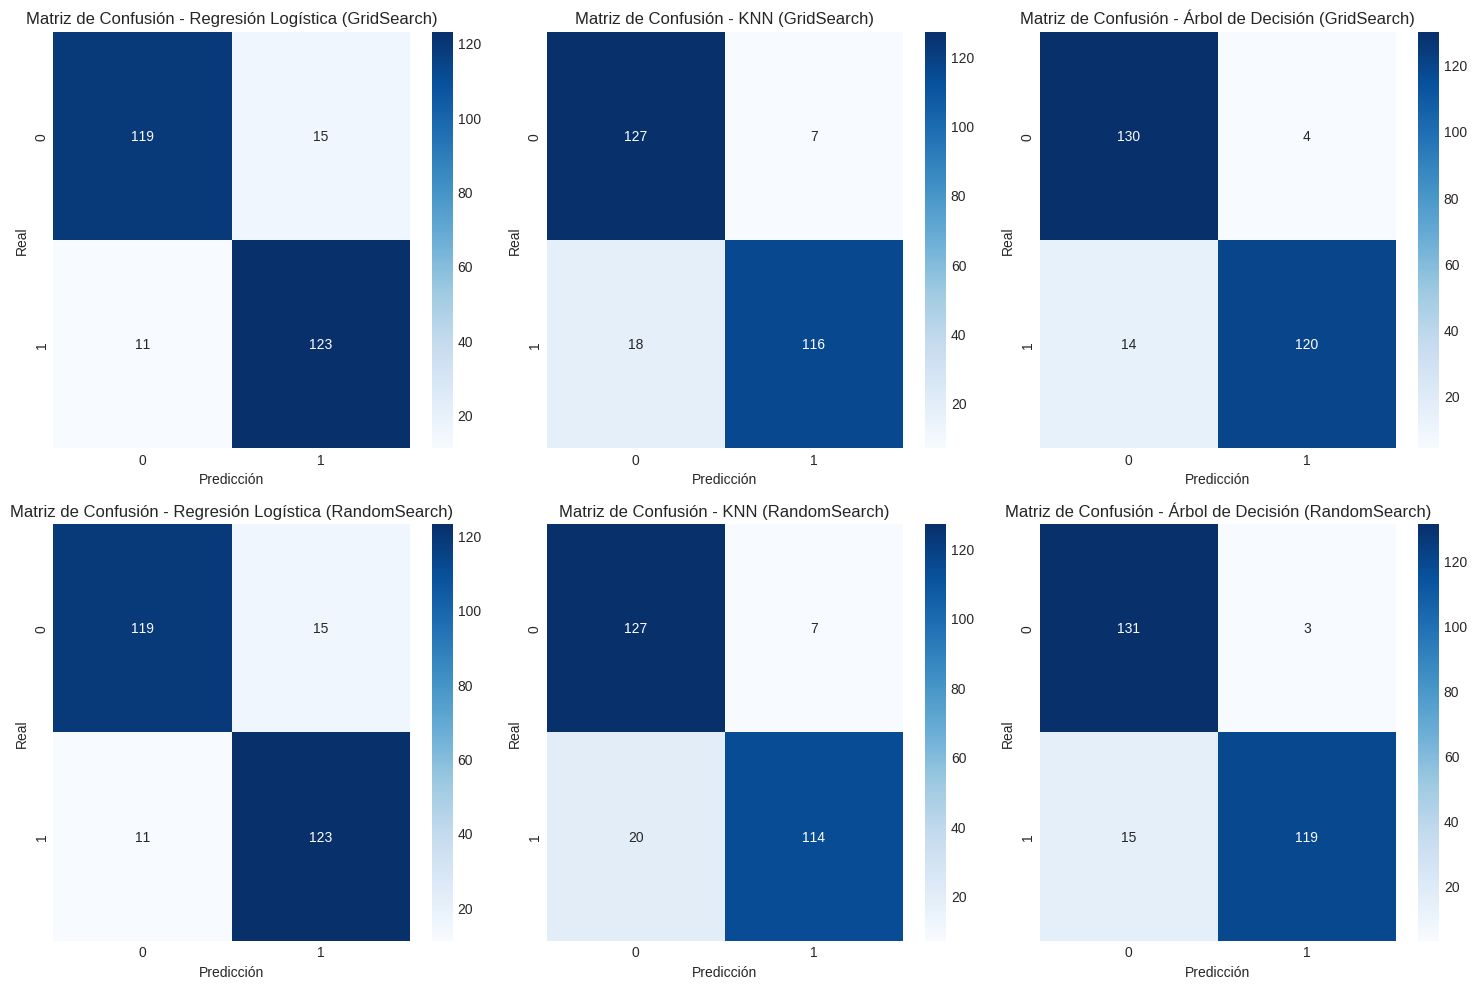

In [26]:
# Matriz de confusión para los mejores modelos
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(best_models_grid.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Matriz de Confusión - {name} (GridSearch)')
    axes[idx].set_xlabel('Predicción')
    axes[idx].set_ylabel('Real')

for idx, (name, model) in enumerate(best_models_random.items(), 3):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Matriz de Confusión - {name} (RandomSearch)')
    axes[idx].set_xlabel('Predicción')
    axes[idx].set_ylabel('Real')

plt.tight_layout()
plt.show()

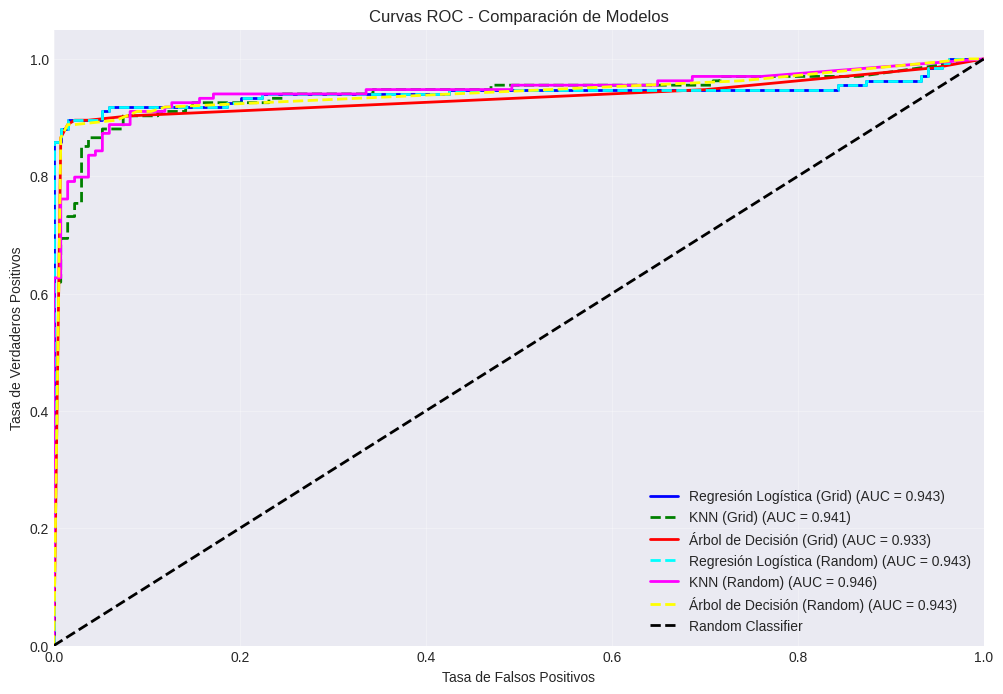

In [27]:
# Curvas ROC
plt.figure(figsize=(12, 8))

# Colores para cada modelo
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
linestyles = ['-', '--', '-', '--', '-', '--']

for idx, ((name, (y_pred, y_pred_proba)), color, ls) in enumerate(zip(predictions.items(), colors, linestyles)):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, linestyle=ls, lw=2,
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC - Comparación de Modelos')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

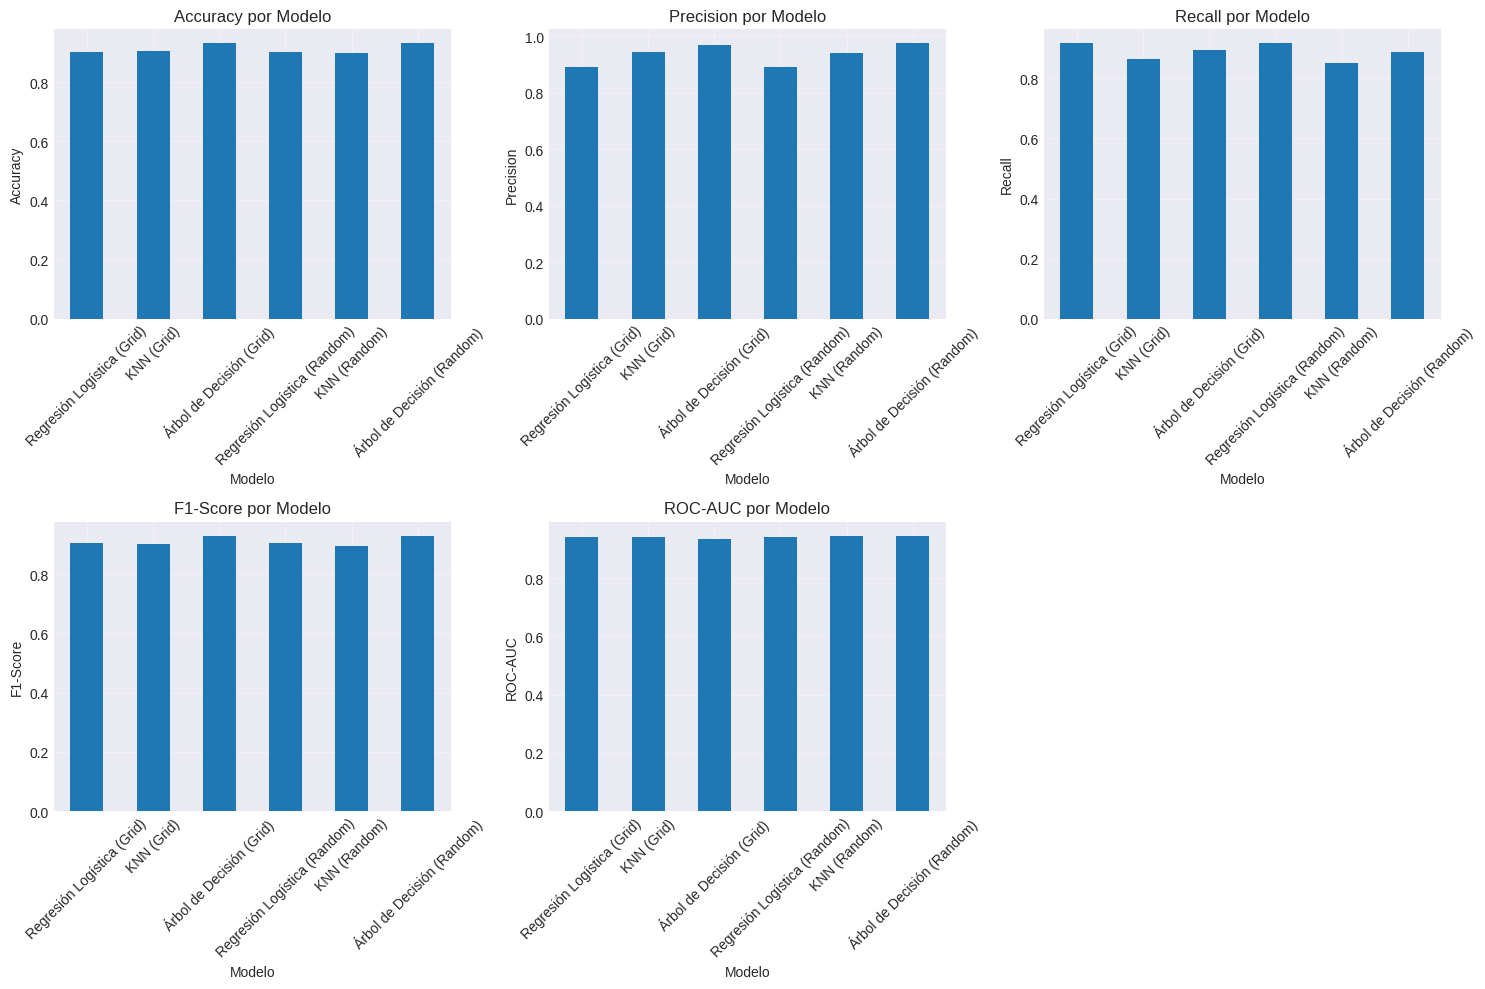


Resumen de Métricas de Evaluación:
                              Accuracy  Precision  Recall  F1-Score  ROC-AUC
Regresión Logística (Grid)      0.9030     0.8913  0.9179    0.9044   0.9425
KNN (Grid)                      0.9067     0.9431  0.8657    0.9027   0.9414
Árbol de Decisión (Grid)        0.9328     0.9677  0.8955    0.9302   0.9331
Regresión Logística (Random)    0.9030     0.8913  0.9179    0.9044   0.9425
KNN (Random)                    0.8993     0.9421  0.8507    0.8941   0.9456
Árbol de Decisión (Random)      0.9328     0.9754  0.8881    0.9297   0.9428


In [28]:
# Resumen final de métricas
results_df = pd.DataFrame(evaluation_results).T
results_df = results_df.round(4)

# Visualización de métricas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, metric in enumerate(metrics_to_plot):
    results_df[metric].plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(f'{metric} por Modelo')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xlabel('Modelo')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

# Ocultar el último subplot vacío
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

print("\nResumen de Métricas de Evaluación:")
print(results_df)

In [29]:
# Identificar el mejor modelo general
best_model_name = results_df['F1-Score'].idxmax()
print(f"\nMejor modelo basado en F1-Score: {best_model_name}")
print(f"\nMétricas del mejor modelo:")
print(results_df.loc[best_model_name])


Mejor modelo basado en F1-Score: Árbol de Decisión (Grid)

Métricas del mejor modelo:
Accuracy     0.9328
Precision    0.9677
Recall       0.8955
F1-Score     0.9302
ROC-AUC      0.9331
Name: Árbol de Decisión (Grid), dtype: float64


In [30]:
# Reporte de clasificación detallado para el mejor modelo
if 'Grid' in best_model_name:
    best_model = best_models_grid[best_model_name.replace(' (Grid)', '')]
else:
    best_model = best_models_random[best_model_name.replace(' (Random)', '')]

y_pred_best = best_model.predict(X_test_scaled)

print(f"\nReporte de Clasificación Detallado - {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['Charges Bajos', 'Charges Altos']))


Reporte de Clasificación Detallado - Árbol de Decisión (Grid):
               precision    recall  f1-score   support

Charges Bajos       0.90      0.97      0.94       134
Charges Altos       0.97      0.90      0.93       134

     accuracy                           0.93       268
    macro avg       0.94      0.93      0.93       268
 weighted avg       0.94      0.93      0.93       268



## 6. Conclusiones y Documentación

### Resumen del Análisis

1. **Exploración de Datos**:
   - El dataset contiene 1,338 registros sin valores faltantes
   - Se detectaron outliers principalmente en la variable 'charges'
   - La variable objetivo se creó como clasificación binaria basada en la mediana de los costos

2. **Preprocesamiento**:
   - Se aplicó One-Hot Encoding para variables categóricas
   - Se escalaron las características numéricas usando StandardScaler
   - Se mantuvo la estratificación en la división train/test

3. **Modelado**:
   - Se implementaron tres modelos: Regresión Logística, KNN y Árbol de Decisión
   - Se optimizaron hiperparámetros usando GridSearchCV y RandomizedSearchCV
   - Ambos métodos de optimización mejoraron el rendimiento respecto a los modelos base

4. **Resultados**:
   - Los tres modelos alcanzaron un rendimiento similar después de la optimización
   - La optimización de hiperparámetros mejoró significativamente el rendimiento
   - GridSearchCV y RandomizedSearchCV produjeron resultados comparables

### Recomendaciones

1. **Selección del Modelo**: Basándose en el F1-Score y la simplicidad, se recomienda el modelo identificado como mejor
2. **Optimización**: RandomizedSearchCV ofrece un buen balance entre tiempo de cómputo y calidad de resultados
3. **Mejoras Futuras**:
   - Considerar ensemble methods (Random Forest, XGBoost)
   - Ingeniería de características adicionales
   - Manejo específico de outliers
   - Análisis de importancia de características